## EM algorithm for classification

In [1]:
import pandas as pd
import numpy as np
import random
import scipy.stats
import matplotlib.pyplot as plt

In [2]:
Xtrain = pd.read_csv('data/Xtrain.csv',header = None)
ytrain = pd.read_csv('data/ytrain.csv',header = None)
ytrain = ytrain.rename(columns={0:'y'})
train_data = pd.concat([Xtrain,ytrain],axis=1)
train0 = train_data[train_data['y']==0].reset_index().drop(['index'],axis=1)
train1 = train_data[train_data['y']==1].reset_index().drop(['index'],axis=1)
Xtrain0 = train0.iloc[:,0:10]
Xtrain1 = train1.iloc[:,0:10]
mu0 = Xtrain0.mean(axis=0)
mu1 = Xtrain1.mean(axis=0)

In [3]:
def rand_init(k):
    sample0 = np.random.multivariate_normal(mu0,Xtrain0.cov(),10)
    sample1 = np.random.multivariate_normal(mu1,Xtrain1.cov(),10)
    mean0 = []
    mean1 = []
    cov0 = []
    cov1 = []
    for i in range(0,k):
        mean0.append(sample0[random.randint(0,9)])
        mean1.append(sample1[random.randint(0,9)])
        cov0.append(Xtrain0.cov())
        cov1.append(Xtrain1.cov())

    return mean0, mean1, cov0, cov1

## E step optimized

In [4]:
def e_step(mean, cov, k, pi, dataset):
    phi = []
    a = []
    
    for o in range(0,k):        
        a.append(pi[o]*scipy.stats.multivariate_normal.pdf(dataset,mean=mean[o],cov=cov[o],allow_singular=False))
    den = np.sum(np.array(a),axis=0)
    
    for n in range(0,k):
        num = pi[n] * scipy.stats.multivariate_normal.pdf(dataset,mean=mean[n],cov=cov[n],allow_singular=False)
        phi.append(np.divide(num,den))
    
    # returns k*n matrix
    return np.array(phi)

## M step optimized

In [5]:
def m_step(mean, phi, dataset, k):
    nk = np.sum(phi.T,axis=0)
    pi_k = nk/dataset.shape[0]
    mu_k = []
    for j in range(0,k):
        mu = (1/nk[j]) * (np.matmul(phi[j],dataset))
        mu_k.append(mu)

    # returns a k*10 array
    mu_k = np.array(mu_k)

    cov_k = []
    for l in range(0,k):
        cov = (1/nk[l]) * np.matmul(np.multiply(phi[l].T,(dataset-mu_k[l]).T), (dataset-mu_k[l]))
        cov_k.append(cov)

    # returns a 10*10 array
    cov_k = np.array(cov_k)

    inner_sum = []
    for t in range(0,k):
        inner_sum.append(pi_k[t]*scipy.stats.multivariate_normal.pdf(dataset,mean=mu_k[t],cov=cov_k[t],allow_singular=False))
    inner_sum = np.sum(np.array(inner_sum),axis=0)
    obj = np.sum(np.log(inner_sum))
    return mu_k, phi, pi_k, cov_k, obj

In [6]:
def superfunc(k):
    best_objs = []
    best_mus = []
    best_covs = []
    best_pis = []
    all_runs_objs = []
    for mail in range(0,2):
        if mail == 0:
            data = np.array(Xtrain0)
        if mail == 1:
            data = np.array(Xtrain1)
        all_runs_obj = []
        best_obj = 0
        for runs in range(0,10):
            mu_k0, mu_k1, cov_k0, cov_k1 = rand_init(k)
            pi_k = [1/k] * k
            all_obj = []

            for t in range(0,30):
                if mail == 0:
                    phi = e_step(mu_k0, cov_k0, k, pi_k, data)
                    mu_k0, phi, pi_k, cov_k0, obj = m_step(mu_k0, phi, data, k)

                    if obj > best_obj:
                        best_obj = obj
                        best_mu = mu_k0
                        best_cov = cov_k0
                        best_pi = pi_k

                
                if mail == 1:
                    phi = e_step(mu_k1, cov_k1, k, pi_k, data)
                    mu_k1, phi, pi_k, cov_k1, obj = m_step(mu_k1, phi, data, k)

                    if obj > best_obj:
                        best_obj = obj
                        best_mu = mu_k1
                        best_cov = cov_k1
                        best_pi = pi_k

                all_obj.append(obj)
            all_runs_obj.append(all_obj)
        best_mus.append(best_mu)
        best_covs.append(best_cov)
        best_pis.append(best_pi)
        all_runs_objs.append(all_runs_obj)
        
    return best_mus,best_covs,best_pis,all_runs_objs

In [7]:
k = 3
best_mus,best_covs,best_pis,all_runs_objs = superfunc(3)

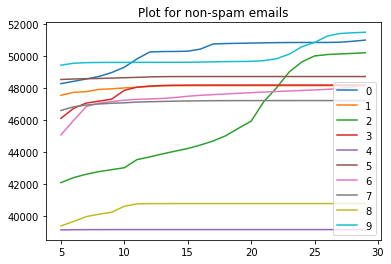

In [365]:
c=0
for e in all_runs_objs[0]:
    plt.plot(range(5,30),e[5:30],label = c)
    plt.legend()
    c=c+1
plt.title("Plot for non-spam emails")
plt.show()

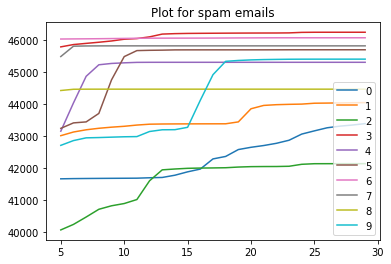

In [366]:
c=0
for e in all_runs_objs[1]:
    plt.plot(range(5,30),e[5:30],label = c)
    plt.legend()
    c=c+1
plt.title("Plot for spam emails")
plt.show()

In [368]:
Xtest = pd.read_csv('data/Xtest.csv',header = None)
ytest = pd.read_csv('data/ytest.csv',header = None)

In [369]:
spam = np.array(Xtrain1)
non_spam = np.array(Xtrain0)

In [370]:
ps = spam.shape[0]/(non_spam.shape[0]+spam.shape[0])
pns = non_spam.shape[0]/(non_spam.shape[0]+spam.shape[0])
pns

0.6060386473429952

In [371]:
test = np.array(Xtest)

In [428]:
k = 4
best_mus,best_covs,best_pis,all_runs_objs = superfunc(k)

In [429]:
spam_bayes = []
for u in range(0,k):
    spam_bayes.append(ps * (best_pis[1][u]*scipy.stats.multivariate_normal.pdf(test,mean=best_mus[1][u],cov=best_covs[1][u])))

spam_pred = list(np.sum(np.array(spam_bayes),axis=0))

In [430]:
nonspam_bayes = []
for u in range(0,k):
    nonspam_bayes.append(ps * (best_pis[0][u]*scipy.stats.multivariate_normal.pdf(test,mean=best_mus[0][u],cov=best_covs[0][u])))

nonspam_pred = list(np.sum(np.array(nonspam_bayes),axis=0))

In [431]:
pred = []
for a,b in zip(spam_pred,nonspam_pred):
    if a>b:
        pred.append(1)
    else:
        pred.append(0)

In [432]:
y = list(np.array(ytest))

In [433]:
# find model accuracy
tp = 0
tn = 0
fp = 0
fn = 0

c_matrix = np.array([[0,0],[0,0]])

for u,v in zip(list(y),pred):

    if (int(u)==v==0):
        tn += 1
    if (int(u)==v==1):
        tp += 1
    if ((int(u) == 0) & (v == 1)):
        fp += 1
    if ((int(u) == 1) & (v == 0)):
        fn += 1

c_matrix_inter = np.array([[tp, fp],[fn, tn]])
c_matrix = np.add(c_matrix, c_matrix_inter)

In [434]:
c_matrix

array([[171,  68],
       [ 11, 210]])

In [435]:
accuracy = (c_matrix[0][0] + c_matrix[1][1])/len(Xtest.index)
print("Accuracy: " + str(accuracy*100))

Accuracy: 82.82608695652173
